#Criação de MLP - Recomendação de Bolsas de Estudo para Alunos

Este notebook tem como objetivo desenvolver um Perceptron Multilayer (MLP) para recomendar bolsas de estudo a alunos com base em seu desempenho acadêmico. É importante destacar que outras características também podem ser adicionadas ao modelo para torná-lo mais robusto e preciso.

#Importação das bibliotecas necessárias

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.optimizers import Adam
from keras.metrics import Precision
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tqdm.keras import TqdmCallback
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Carregando o conjunto de dados preparado para a recomendação de bolsas de estudos

In [ ]:
df = pd.read_csv('/content/processado_base_ml_bolsa.csv', sep=';')
df.head()

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
0,10.00002,7.581705,7.5,8.816667,5.625000,7.916665,5.0,7.675509,1
1,10.00002,8.071429,7.5,5.083333,6.250000,8.055553,5.0,7.117065,0
2,6.41668,8.557505,7.5,7.083333,6.458333,7.833337,5.0,7.232336,0
3,9.00002,9.333333,7.5,5.500000,6.250000,7.500000,10.0,7.741669,0
4,10.00002,9.314954,7.5,5.583333,5.937500,7.916670,5.0,7.406743,0


In [ ]:
# Realiza um embaralhamento para assegurar a aleatoriedade da amostra.
df = shuffle(df, random_state=800)

# arredonda os indicadores
df = df.round(2)

In [ ]:
df.head()

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
596,0.00,5.21,4.38,5.44,7.50,6.92,5.0,5.20,1
9,9.50,6.65,7.50,5.50,5.94,7.50,5.0,6.72,0
842,6.83,8.08,7.50,3.25,5.00,5.06,5.0,5.71,0
769,8.00,9.67,7.50,3.25,6.25,7.33,5.0,6.73,0
652,7.42,7.43,7.50,8.83,6.04,7.28,5.0,7.30,0


In [ ]:
set(df['INDICADO_BOLSA'])

{0, 1}

In [ ]:
df['INDICADO_BOLSA'].value_counts() #percebemos uma disparidade na quantidade de alunos que foram indicados a bolsa e os que não foram

,count
INDICADO_BOLSA,
0,730
1,132



#Simulando e aprimorando os dados de treinamento

Nesta seção, adicionamos alguns dados simulados para enriquecer o conjunto de dados de alunos.

*   200 registros de alunos com notas >= 8 nos indicadores, representando ótimos

*   100 registros de alunos com notas >= 0 e <= 5 nos indicadores, indicando alunos que não deveriam receber uma indicação de bolsa.

Esses dados simulados têm como objetivo incrementar o conjunto de dados de treinamento e melhorar a performance da rede neural.

In [ ]:
colunas = df.columns.difference(['INDICADO_BOLSA'])

In [ ]:
simu_alunos1 = np.random.uniform(8, 10, size=(200, len(colunas)))
simu_alunos1 = pd.DataFrame(simu_alunos1, columns=colunas)
simu_alunos1['INDICADO_BOLSA'] = 1
simu_alunos1

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,8.059116,9.496333,9.614103,8.138089,9.080421,9.749297,8.248917,9.951106,1
1,8.087235,9.583971,8.466629,9.522939,8.357836,8.972953,9.354005,9.915084,1
2,8.975563,8.382477,9.404562,8.491153,8.334249,9.121037,8.948487,9.506500,1
3,8.313249,9.097681,9.294857,9.031312,8.462950,9.940739,8.201214,8.086185,1
4,8.012832,9.967413,9.509565,8.086761,9.520323,9.211685,8.292573,8.483756,1
...,...,...,...,...,...,...,...,...,...
195,9.111738,8.542407,8.992681,8.951690,9.400225,9.899094,8.560647,8.014571,1
196,8.061674,8.279239,8.115323,9.584020,9.416303,9.180740,9.036815,9.995530,1
197,8.623033,8.331384,9.092037,9.726331,9.981588,8.664416,9.872132,8.621095,1
198,8.146917,9.751828,9.311394,9.489762,9.783542,9.962096,9.315314,9.061765,1


In [ ]:
simu_alunos2 = np.random.uniform(0, 5, size=(400, len(colunas)))
simu_alunos2 = pd.DataFrame(simu_alunos2, columns=colunas)
simu_alunos2['INDICADO_BOLSA'] = 0
simu_alunos2

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,1.379762,4.897408,1.788250,0.940165,4.256772,1.540687,0.536627,2.561859,0
1,2.214506,2.569407,3.371278,3.202622,3.825748,4.664943,1.415617,1.328736,0
2,2.310920,4.174315,4.316317,4.913541,1.018470,0.191905,1.216813,0.991958,0
3,1.138671,0.681491,0.837051,1.240242,3.273947,4.685369,1.791162,4.893665,0
4,1.387730,0.165333,3.499888,1.281605,0.341324,4.691334,2.026805,3.378987,0
...,...,...,...,...,...,...,...,...,...
395,4.068589,1.031886,0.729899,1.574771,4.762671,4.585764,0.788480,0.805816,0
396,4.781994,1.673953,2.154456,0.978514,3.382563,3.598109,2.292358,4.515464,0
397,1.520711,0.680774,4.290953,1.648329,3.100658,1.772117,1.702497,4.769666,0
398,0.973696,1.963536,2.119112,2.703057,3.477395,4.412988,0.598267,0.769013,0


In [ ]:
df = pd.concat([df, simu_alunos1, simu_alunos2], ignore_index=True) #concatenando os dados num único dataframe

#Preparando o conjunto de dados para o treinamento e validação da rede neural.

In [ ]:
# features
X = df[df.columns.difference(['INDICADO_BOLSA'])]
# targets
y = df['INDICADO_BOLSA']

In [ ]:
X

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV
0,0.000000,5.000000,5.440000,5.210000,5.200000,7.500000,4.380000,6.920000
1,9.500000,5.000000,5.500000,6.650000,6.720000,5.940000,7.500000,7.500000
2,6.830000,5.000000,3.250000,8.080000,5.710000,5.000000,7.500000,5.060000
3,8.000000,5.000000,3.250000,9.670000,6.730000,6.250000,7.500000,7.330000
4,7.420000,5.000000,8.830000,7.430000,7.300000,6.040000,7.500000,7.280000
...,...,...,...,...,...,...,...,...
1457,4.068589,1.031886,0.729899,1.574771,4.762671,4.585764,0.788480,0.805816
1458,4.781994,1.673953,2.154456,0.978514,3.382563,3.598109,2.292358,4.515464
1459,1.520711,0.680774,4.290953,1.648329,3.100658,1.772117,1.702497,4.769666
1460,0.973696,1.963536,2.119112,2.703057,3.477395,4.412988,0.598267,0.769013


In [ ]:
y

,INDICADO_BOLSA
0,1
1,0
2,0
3,0
4,0
...,...
1457,0
1458,0
1459,0
1460,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

StandardScaler()

In [ ]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape #verificando o tamanho da base x de treino

(1169, 8)

In [ ]:
X_test.shape #verificando o tamanho da base x de teste

(293, 8)

In [ ]:
# Verificando se a soma dos tamanhos da base de treino e teste é igual a base de dados original
X_train.shape[0] + X_test.shape[0] == df.shape[0]

True

In [ ]:
y_train = np.asarray(y_train).reshape((-1, 1))
y_test = np.asarray(y_test).reshape((-1, 1))

In [ ]:
X_train[:5]

array([[-1.62395724, -1.21696665, -1.48320915, -2.06690753, -1.10500017,
        -0.52702356, -1.57008215, -2.02905972],
       [ 0.5189739 , -0.27343857, -1.18420045,  1.17714819,  0.24395443,
         0.33698875,  0.57797814,  0.48176863],
       [ 0.33938446, -0.27343857,  0.18735329, -0.13070584,  0.21503222,
         0.77815934,  0.32800257,  0.44978067],
       [ 0.67379238, -0.27343857,  1.22076775,  0.84582517,  0.76868592,
         0.24790623,  0.57797814,  0.81364374],
       [-1.02649731, -1.49039131, -1.73594858, -1.18224349, -2.52045287,
        -2.36776038, -1.78196211, -0.96907218]])

In [ ]:
y_train[:5]

array([[0],
       [0],
       [0],
       [1],
       [0]])

#Desenvolvendo a rede neural Multilayer Perceptron

In [ ]:
# Semente aleatótia para manter os mesmos dados
tf.random.set_seed(800)

# Definindo entradas da rede + tamanho da batch de processamento
input_shape = X_train.shape[1]    # Variáveis de entrada
output_shape = y_train.shape[1]   # Classe preditora
batch_size = 32

# Abrindo uma sequencia de neuronios
model = models.Sequential()

# input layer
# Entrada da rede
model.add(layers.Dense(batch_size,input_shape=(input_shape,),activation='relu'))

# hidden layer
# Camada oculta
model.add(layers.Dense(8,activation='relu'))

# dropout layer
# Aplicando regularização
model.add(layers.Dropout(0.5))

# output layer
# Camada de saída
model.add(layers.Dense(output_shape, activation='sigmoid'))

# Configurar o otimizador Adam com uma learning rate específica
# Defina a learning rate desejada
learning_rate = 0.000015
otimizador = Adam(learning_rate=learning_rate)

# Compilar o modelo com o otimizador configurado
model.compile(loss='binary_crossentropy', optimizer=otimizador, metrics=['accuracy'])

# Monitor para interromper o modelo antecipadamente quando a melhoria da perda de validação for mínima
monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto') #Aqui utilizando early stopping

# summmary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 561 (2.19 KB)

 Trainable params: 561 (2.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configurando as épocas de processamento para a convergência do erro da função de custo
epoch = 1750

hist = model.fit(X_train,y_train,epochs = epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test, y_test),verbose=0,callbacks=[TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

In [ ]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"O modelo possui uma acurácia de {acc} com {epoch} epochs de processamento")

O modelo possui uma acurácia de 88.88% com 1750 epochs de processamento


#Validando a rede neural

In [ ]:
model_training_data_hist = pd.DataFrame(hist.history) #foi gerado um dataframe deste histórico de treinamento

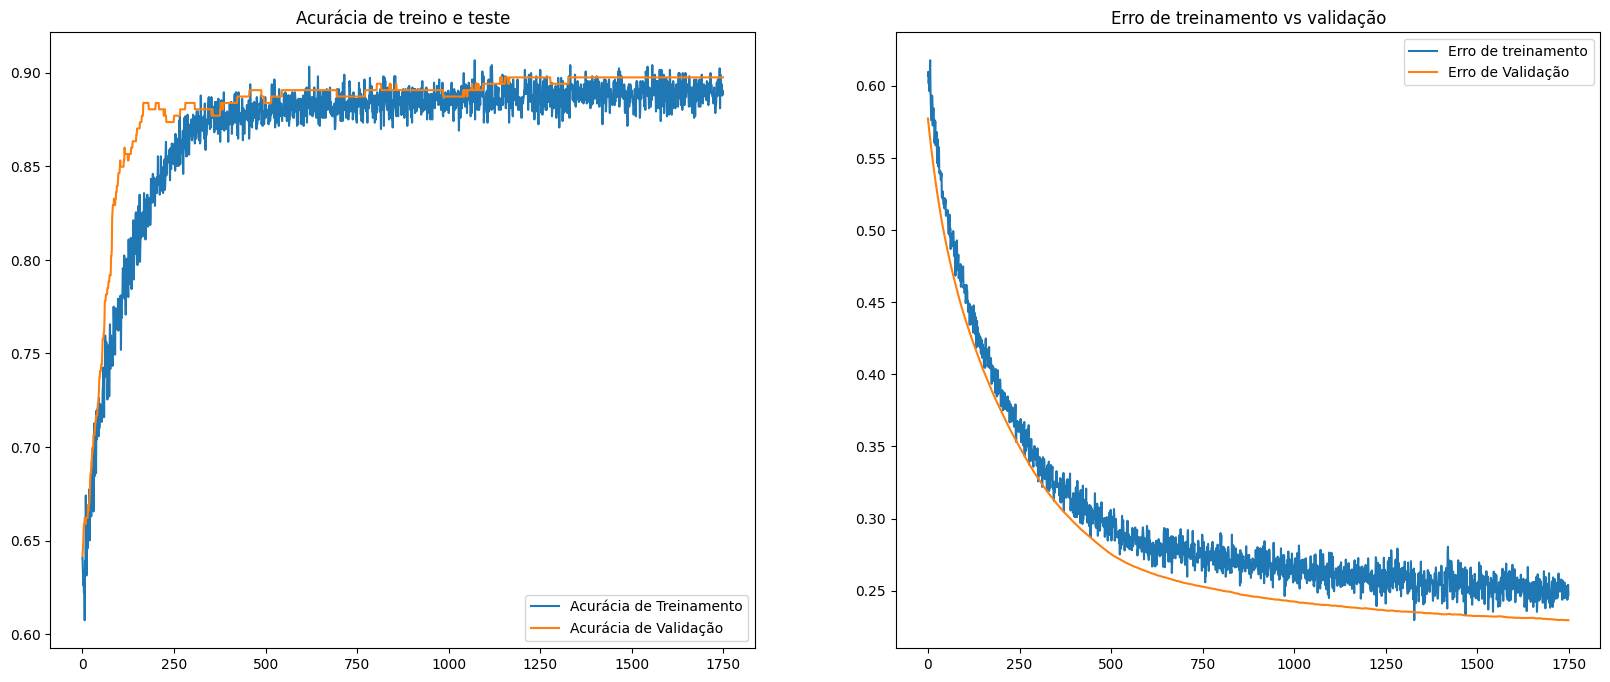

In [ ]:
# Visualizando os resultados de treino
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

# Plot Acurácia
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e teste')

# Plot Erro de treinamento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_class = [round(x[0]) for x in y_pred]
y_test_class = y_test

# classification report
class_names = ['Não', 'Sim']

print(classification_report(y_test_class, y_pred_class, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

         Não       0.92      0.96      0.94       226
         Sim       0.82      0.70      0.76        67

    accuracy                           0.90       293
   macro avg       0.87      0.83      0.85       293
weighted avg       0.89      0.90      0.89       293



#Exportação da rede e do scaler

In [ ]:
model.save('multilayer-perceptron.keras')

In [ ]:
import joblib

In [ ]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']